<h1>ELEN0016-2 - Computer vision</h1>
<h2>Student project - Part 1 : Main modules developement and line extraction</h2>
<h3>University of Liège - Academic year 2019-2020</h3>
<h3>Maxime Meurisse - François Rozet - Océane Rumfels - Valentin Vermeylen</h3>

<h2>Introduction</h2>

<h3>Presentation</h3>

As mentioned in the statement, the whole project is about *detecting lines and finding elliptical objects in images*. This part of the project focuses on *the developement of an application for image/video processing and the detection / extraction of straight lines only*.  
To accomplish this task, we wrote a program that performs several processes on an image : a pre-processing (masking, color management, blurring, ...), an extraction of local edges (or feature) points, a detection of lines based on these points and finally a classification of the points in order to know if they belong to a segment or not.  
Our program is capable of processing an image, image folder or video. Its use is clearly explained in the `README.md` file attached to the code.  
Working on several types of images, we have adapted our algorithms to obtain the best possible result for each case. Our choices and results will be discussed throughout this notebook.

<h3>Image selection</h3>

We chose from the provided database three types of images for which we developed specialized algorithms : **sudoku**, **soccer** and **road** pictures. Although we will mainly focus on sudoku and soccer in this report as they were the algorithms that provided the best results and as the number of pages is limited, we still included some discussions regarding the roads as the reasons for why that algorithm does not work perfectly are worth explaining.

<h3>Contribution of group members</h3>

In general, the whole group was interested in each task of the project. First of all, we discussed together briefly the algorithms and techniques that we could use for each case. We also thought about the architecture of the code. We then divided the work among ourselves to be effective.

**Maxime** focused on writing the code : he created the different files according to the chosen architecture and specified the functions. He then focused on the different stages of Sudoku in order to obtain a suitable result. Finally, he tested the algorithms on the other types of images.  
**François** also actively participated in the writing of the code and its organization. He improved the Sudoku and focused mainly on the images of the football field. He tried several techniques for each task in order to obtain the best result.  
**Océane** first focused on pre-processing operations : she tried several techniques on the different types of images in order to compare them and allow us to choose the most appropriate one. She then focused on writing the notebook by explaining and discussing in a general way the parameters of the different methods.  
**Valentin** focused on the images of the road. As the basic methods were not always effective given the wide variety of these images, he tried to find the best possible pre-processing in order to obtain acceptable results. He was also actively involved in the writing of the notebook.

<h2>Preliminary tasks</h2>

<h3>Module import</h3>

We import the modules we need.

In [1]:
import cv2
import tools

<h3>Preprocessing</h3>

Preprocessing our images is a very important task in edge detection. It enables us to filter out some uninteresting edge points in an image, by reducing as much as possible the noise and by highlighting features particular to the image class.

<h4>Sudoku</h4>

After several tests, we chose to settle for a bilateral filter, which will conserve the edges of the image while reducing the noise. Unlike a gaussian filter, the bilateral filter will consider the values of the neighbors and not just perform a linear combination of them.

While the gaussian filter did perform well, <b>on</b> average, the bilateral filter gives better results.

To get the best filtering results, we chose, empirically, the following parameters :

* `d` = 10 : diameter of each pixel neighborhood.
* `sigma_color` = 10 : the higher this value is, the more the algorithm will consider pixels with different colors in the vicinity of the processed pixel to mix them together.
* `sigma_space` = 100 : the higher this value is, the more the algorithm will consider pixels far away with a color more or less similar to the processed pixel to mix them together.

Indeed, since `sigma_color` is low and `sigma_space` is high, the filter equalizes the zones of low contrast in the image, i.e. the page background, while keeping sharp the sudoku grid and the text.

<h4>Road</h4>

Preprocessing the road images was more complex than the filtering done for the sudoku images. Indeed, we encoutered several problems to blur background elements like trees or the sky, and this had a huge impact on the edge detection section. Filtering was thus very important.

Firstly, we tried to simply implement a bilateral filter followed by a Gaussian blurring  and finish by substracting a threshold mask from the processed image to filter most of the trees. That worked, but we still had a lot of noise and lines being detected in the trees, and it did not much for the sky, so we tried something else.  
We settled for the following method : we first filter the white components in hsv colorspace (everything that is not white becomes black), and then we remove the sky via contours (contours that are above a given area are filtered out). In doing so, we removed most of the reflection of the sky on the road (via the hsv filtering) and parts of the sky (via contour deletion), but we also lost lanes that were darkened (not white enough to be considered lanes) and big lane elements, as their areas were too high.  
We set the area above which the elements were deleted as 8000, the lower and upper bounds for the HSV mask as (0,0,235) and (255, 255, 255), as they gave the best results. The parameters of findContours are taken from [this stackoverflow page.](https://stackoverflow.com/questions/10262600/how-to-detect-region-of-large-of-white-pixels-using-opencv)

<h4>Soccer field</h4>

The main difficulty to face with a soccer field is the impressive number of edges (public, players, letters, goal, etc). To solve this problem, we choose to use the colors (in HSV color space) of the playing field to extract edge points only from the field and not the benches, etc. Thus we can also use those specificities to our advantage.

We first use the function `inRange` to find the mask of green pixels of our image, and to peform this, we define the following parameters :

`lower` : lower bound color of the mask we want to select; `upper` : upper bound color of the mask we want to select.

Once we have this mask, we apply it to the image to obtain the corresponding pixels of the image with the function `bitwise_and`. This method was more efficient than using a simple filter.

<h2>Edge point extraction</h2>

In this task, we extracted the local edge (or feature) points of the image. We have seen that there are multiple methods to do this : first-order derivative of the image (using the Sobel or Scharr gradient) or second-order derivatives (Laplacian, Gauss Laplacian, etc.). After a few brief tests, we found that in the vast majority of cases the Canny method provided the best results. This seems logical because Canny's filtering has been developed to be optimal according to several criteria (good detection, good location and clarity of response).

The **Canny algorithm** starts by reducing the image noise by performing Gaussian filtering. Then, the algorithm applies a gradient (Sobel) to obtain the intensity of the contours. Only the points being local maxima on the gradient map are kept for the next step (this reduces the display of the result of applying the gradient to simple and fine lines).

The contours are then differentiated by thresholding. Two thresholds are used and the decision rule is as follows : any point below the low threshold is rejected, any point above the high threshold is retained, any point between the 2 thresholds is retained if it is directly connected to another accepted point.

The use of this method is therefore based on 3 parameters : the low threshold (`low_threshold`), the high threshold (`hi_threshold`) and the filter size (`aperture_size` = `filter_size` in our code).

The larger the filter size, the more blurred the image will be. A small filter therefore produces a slightly blurred image that is suitable for detecting a larger number of lines. On the contrary, an image that is highly blurred by a large filter will only detect a small number of lines (large, well marked lines).

The use of 2 thresholds provides more flexibility. Indeed, it is almost impossible to find a single gradient value as threshold that gives good results. The higher the upper threshold value, the more essential elements could be omitted. The smaller the lower threshold value, the more irrelevant elements could be retained. It is therefore necessary, empirically, to find the right threshold values.

<h3>Sudoku</h3>

There are several methods to extract edge points : first order image derivatives (using the Sobel or Scharr gradient) or second order like Laplacian, Laplacian of Gaussian, etc. But second order methods were observed to be more sensitive to noise and focus more on blob (binary large objects like a body), which are not what we wish to observe in the case of sudokus.

Thus, we chose to implement the Canny method, which uses the derivative of a Gaussian, and the Sobel edge detection operator. And Canny seems to achieve good results.

To get the best results, we chose the following parameters with Canny :

 `low threshold` = 80 ; `high threshold` = 180 ; `aperture_size` = `filter_size` = 3

In order to improve continuity between extracted edge points, we have implemented a Gaussian blur after the Canny algorithm. Indeed, the gaussian blur smoothes the image which connects close edge points.

To get the best results, we chose the following parameters for the Gaussian blur :

 `kernel_size` = (3, 3) ; `sigmaX` (standard deviation in the X direction) = 0 ; `sigmaY` (not specified) = sigmaX

Below, we can observe the preprocessed image.

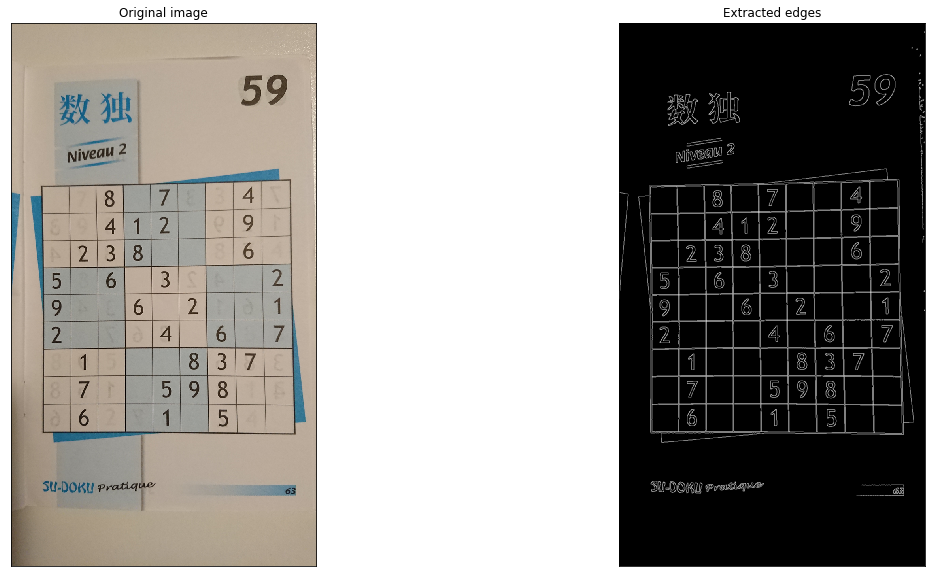

In [2]:
# Load the images
img = cv2.imread('../products/sudoku/sudoku_00188_00.png')
img_edges = cv2.imread('../products/sudoku/sudoku_00188_02.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_edges = cv2.cvtColor(img_edges, cv2.COLOR_BGR2RGB)

# Display the images
tools.multi_plot(1, 2, (img, img_edges), ('Original image', 'Extracted edges'))

We can see on these examples that our algorithm did not detect some of the useless edges like the light blue rectangles. This was achieved thanks to our different filtering processes.
On the other hand, it did detect other writings on the page, but these are the limitation of our techniques.

<h3>Road</h3>

Just like the preprocessing, edge point extraction was harder for the road images than the sudoku ones. A preprocessing work was very important but chosing wisely our edge points extraction method is as relevant and tricky.

First of all, after a few research on the net, we found out that everyone used a Region Of Interest. However, in our case, it would not have worked as the images that were taken were too dissimilar in orientation to have a ROI that worked for every one. But that could, and should, be implemented for contexts in which the camera is fixed (more on that in later discussion).  
Finally we settle on Canny. We tried SobelX because we thought that, as most traffic lines are vertical, it would be a great extraction of what we needed, but we ended up with a lot of noise, and results that were worse than those obtained with Canny.  
To get the best results, we found experimentally the following Canny parameters :

`low_threshold` = 100 ; `high_threshold` = 200 ; `aperture_size` = `filter_size` = 3

After that, we removed the points that were in the upper quarter of the image, as they were most likely to be noise due to buildings or to the sky, but we lost parts of the roads on some photos (the dataset was not standardized enough for this trick to work on every sample).

<h3>Soccer Field</h3>

After the pre-processing step, most pixels outside the field became black. As a result, Canny method produces great results. Moreover, we found experimentally that, in this case, results were barely influenced by Canny parameters.  
Overall, the best parameters are the followings :

 `low_threshold` = 80 ; `high_threshold` = 180 ; `aperture_size` = `filter_size` = 3

As can be seen on the example below, edge points are mostly detected within the field, as expected.

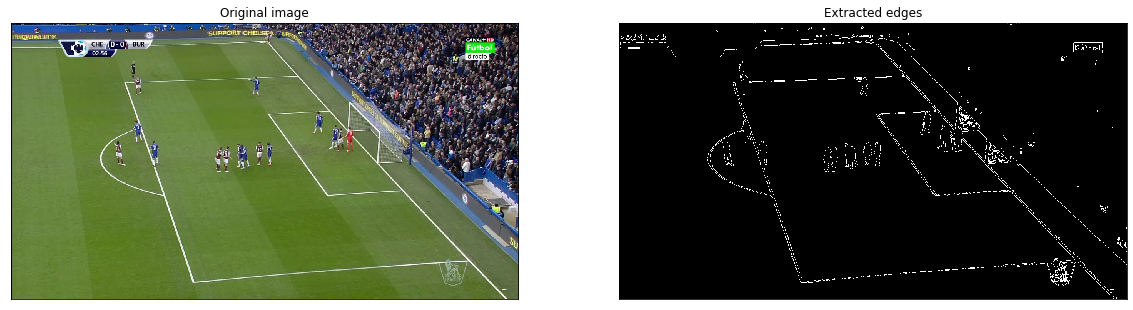

In [3]:
# Load the images
img = cv2.imread('../products/soccer/soccer_00020_00.png')
img_edges = cv2.imread('../products/soccer/soccer_00020_02.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_edges = cv2.cvtColor(img_edges, cv2.COLOR_BGR2RGB)

# Display the images
tools.multi_plot(1, 2, (img, img_edges), ('Original image', 'Extracted edges'))

<h2>Line (segment) detection</h2>

In this task, we have to detect lines (and / or line segments) from the local edge points list extracted previously. We used the probabilistic Hough transform. Here is the list of its parameters and their impact on the results :

* `rho` and `theta` : For every edge, the algorithm will compute multiple pairs $(\rho, \theta)$ for which $\rho$ and $\theta$ are multiples of respectively `rho` and `theta`. Therefore, for larger `rho` and `theta`, fewer calculations are performed, and fewer lines are found;
* `threshold` : Makes it so that the algorithm outputs a segment only if it has more points in it than the threshold. A low value will output more lines, and more noise, but a too high value will not output anything;
* `minLineLength` : The minimum length of the line required for it to be output. A high value will mean less lines provided by that method;
* `maxLineGap` : The maximum gap allowed between points on the same line to link them.

<h3>Sudoku</h3>

To detect lines, we used the probabilistic Hough transform, which executes faster than the classical Hough transform but is less accurate as it samples points (it samples randomly the extreme points). However, it returns directly the edge points of the segments, which is what we want for our application. Furthermore, to be used in real-time videos, the process must be quick. The same choice has been made for the other two classes.

To get the best results, we chose the following parameters with `HoughLinesP` :
`rho` = 1 ; `theta` = $\frac{\pi}{180}$ ; `threshold` = 200 ; `minLineLength` = 300 ; `maxLineGap` = 10.

The minimun line length is large on purpose since we only want to detect long segments of lines (i.e a grid), while the maximum line gap is (very) short to prevent the hough transform to consider the letters and numbers within and outside the grid.  
A consequence to the large minimum length is that, when part of the sudoku is curved, our algorithm has trouble to recognize the curved lines. To correct this behaviour post-processing algorithms could have been implemented, especially with sudokus where we know we have to extract a square grid. Still, the easiest way to solve this problem is symply to improve the acquisition process.

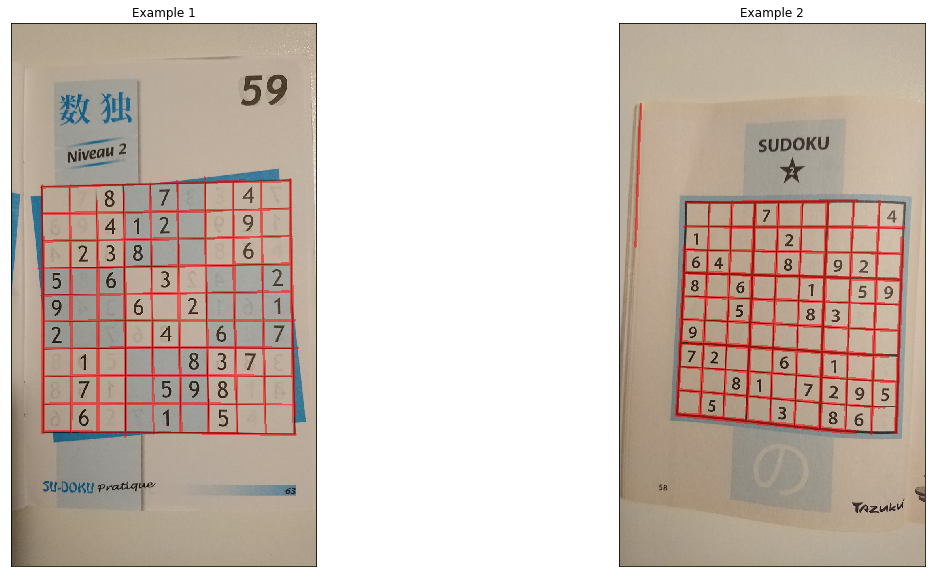

In [4]:
# Load the images
img_lines1 = cv2.imread('../products/sudoku/sudoku_00188_04.png')
img_lines2 = cv2.imread('../products/sudoku/sudoku_00004_04.png')

# Color correction for matplotlib
img_lines1 = cv2.cvtColor(img_lines1, cv2.COLOR_BGR2RGB)
img_lines2 = cv2.cvtColor(img_lines2, cv2.COLOR_BGR2RGB)

# Display the images
tools.multi_plot(1, 2, (img_lines1, img_lines2), ('Example 1', 'Example 2'))

<h3>Soccer Field</h3>

In this section, we also used the probabilistic Hough transform, and we selected the following parameters through testing :

 `rho` = 1 ; `theta` = $\frac{\pi}{180}$ ; `thresh` = 100 ; `minLineLength` = 100 ; `maxLineGap` = 15

Since we wanted to detect long continuous lines (white lines on the field), we took a rather big `minLineLength` and a short `maxLineGap`.  
As for sudokus, we face a problem with circular markings. However, in this case, it is not corrigible through acquisition.  
We could have considered smaller segments to approximate those curves, but then, we would have detected player edges as lines which is obviously not wanted. Another possible way, yet not in the scope of this project part, would have been to implement an ellipse detection algorithm.

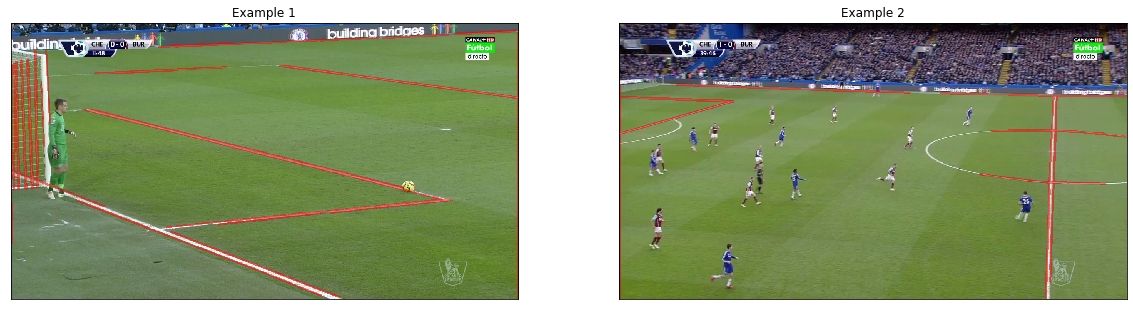

In [5]:
# Load the images
img_lines1 = cv2.imread('../products/soccer/soccer_00095_04.png')
img_lines2 = cv2.imread('../products/soccer/soccer_00321_04.png')

# Color correction for matplotlib
img_lines1 = cv2.cvtColor(img_lines1, cv2.COLOR_BGR2RGB)
img_lines2 = cv2.cvtColor(img_lines2, cv2.COLOR_BGR2RGB)

# Display the images
tools.multi_plot(1, 2, (img_lines1, img_lines2), ('Example 1', 'Example 2'))

<h2>Edge points classification</h2>

In this section, we wish to select the pixels which belong or not to a line. We use the same methods for the three classes so we only discuss one of them.

<h3>Sudoku</h3>

To classify our points, we used the image obtained after the line detection as a mask.  
The concept is the following : we enlarge the thickness of lines and then generate a corresponding binary mask where the value determines if a pixel belongs to a line or not. Then, we use the function `bitwise_and` to select the edge points that belong to the mask and color them in red.

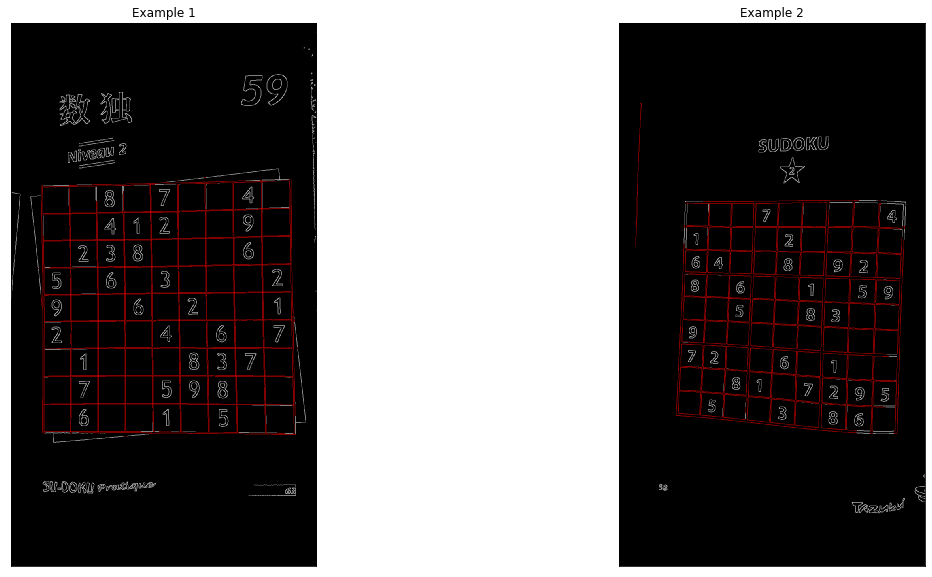

In [6]:
# Load the images
img_class1 = cv2.imread('../products/sudoku/sudoku_00188_03.png')
img_class2 = cv2.imread('../products/sudoku/sudoku_00004_03.png')

# Color correction for matplotlib
img_class1 = cv2.cvtColor(img_class1, cv2.COLOR_BGR2RGB)
img_class2 = cv2.cvtColor(img_class2, cv2.COLOR_BGR2RGB)

# Display the images
tools.multi_plot(1, 2, (img_class1, img_class2), ('Example 1', 'Example 2'))

<h2>Other types of images</h2>

So we developed 3 algorithms (`soccer`, `sudoku` and `road`); each one adapted to a type of image. We tested these algorithms on other types of images (pcb and building).  
The road and soccer algorithms do not give good results. Indeed, these are too specific to their type of image. For example, the soccer algorithm only considers the green areas of the image, which is too specific for other tests.  
So we tested the more general `sudoku` algorithm. This allows long, thick and continuous lines to be correctly identified.

On the **building** images, the result is sometimes good, sometimes bad. On a building with a lot of windows and seen from the front, the result will be good because its appearance could look like a Sudoku grid. On a building seen diagonally with trees and bushes around, the result is very bad : the lines are not marked enough and many other unwanted points are detected.

On **PCB** images, the result is not very good. The contours of the cards are detected, but the internal elements are not. In general, too many points are taken into account and the lines, being too small and thin, are poorly detected. This results in an very poor lines detection where random points are considered to belong to the same segment.

The conclusion is that the perfect algorithm does not exist. A Computer vision algorithm is designed for a particular task, and it cannot be expected to work outside the context it has been developed for.

<h2>Discussion for road</h2>

As we experimented, we could note that some prior image modifications could be made depending on the type of images. Like the use of the colors to increase our performance with the soccer field, same tactics could adopt with specific kind of roads or sudoku grids, as well as for the classes for which we did not design a specialized algorithm.

Unlike soccer and sudoku images, road ones were much more varied, and not standardized. We therefore have much worse results on them than on the two other classes, as we tried to keep an algorithm that stayed quite general for all types of road images that we were given. A simple way to develop a better algorithm in that case would be to work on the acquisition process. Indeed, if the camera was centered on the car and if the angle of view was constant, we could have implemented a more specialized algorithm (ROI, parameters more adapted,...). Here, some of the images were taken in such a way that the road was curved (so our algorithm did not detect them), the camera looked up, or the lighting was poor.

However, we cannot do anything for the poor condition of Europe's road, where it is not uncommon to have faded lines, and we could not catch some dotted lines as, if we had changed some parameters to allow that (bigger maxLineGaps or smaller minLineLength for example), we would have had a lot of noise coming from the sky, the leaves... In the end, our algorithm works better when the lines are not faded (as we filter the white component) and when the camera is centered. Expecting a simple (not ML) algorithm to detect lanes on highways and in villages with equal perfection is not possible. 

<h2>Try it yourself</h2>

In this section, you can test the complete lines detection procedure on the image you want.

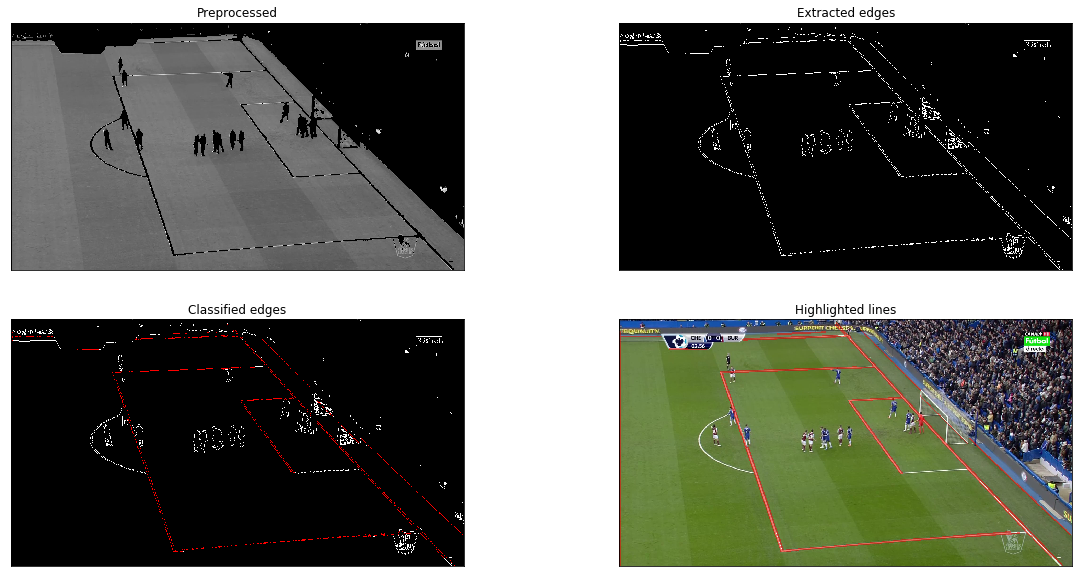

In [7]:
# Line detection procedure
from utils import procedure

# Process class (sudoku, soccer or road)
from soccer import Process

# Image you want to process
img_path = '../resources/images/soccer/soccer_00020.png'

# Don't change this
img_list = list()

for img in procedure(img_path, Process):
    img_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

tools.multi_plot(2, 2, tuple(img_list[1:]),
    ('Preprocessed', 'Extracted edges', 'Classified edges', 'Highlighted lines')
)

<h2>References</h2>

To achieve this part of the project, we consulted several references.

* [Image thresholding - OpenCV](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
* [Canny edge detection - OpenCV](https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html)
* [Hough line transform - OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html)
* [Edge detection - Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector)
* [Canny edge detector - Wikipedia](https://en.wikipedia.org/wiki/Canny_edge_detector)
* [Sobel operator - Wikipedia](https://en.wikipedia.org/wiki/Sobel_operator)
* [Hough transform - Wikipedia](https://en.wikipedia.org/wiki/Hough_transform)
* [Simple Lane Detection with OpenCV - Medium](https://medium.com/@mrhwick/simple-lane-detection-with-opencv-bfeb6ae54ec0)
